# 3 Level system

In [3]:
import numpy as np
import qutip as qt

def build_ops():
    e1, e2, e3 = qt.basis(3,0), qt.basis(3,1), qt.basis(3,2)
    def sigma(i,j):
        basis = [e1,e2,e3]
        return basis[i-1]*basis[j-1].dag()
    return {
        "e1": e1, "e2": e2, "e3": e3,
        "s11": sigma(1,1), "s22": sigma(2,2), "s33": sigma(3,3),
        "s13": sigma(1,3), "s31": sigma(3,1),
        "s23": sigma(2,3), "s32": sigma(3,2),
    }

def make_H_and_cops(ops, delta, Delta2, Omega_p_fn, Omega_s_fn, gammas):
    """
    Construye el Hamiltoniano H y los operadores de colapso (c_ops) para la
    simulación completa de la ecuación maestra de Lindblad.

    H_s(t) es el Hamiltoniano coherente (RWA).
    c_ops incluye Decaimiento Espontáneo (|3> -> |1>, |2>) y Desfase Puro (|i><i|).
    
    Se espera que gammas sea una tupla de cinco elementos:
    (gamma_3_to_1, gamma_3_to_2, gamma_deph_1, gamma_deph_2, gamma_deph_3)
    """
    
    # 1. Componentes del Hamiltoniano (H)
    s11, s22, s33 = ops["s11"], ops["s22"], ops["s33"]
    
    # Operadores de acoplamiento de campo (sin coeficientes 0.5)
    Hp = ops["s31"] + ops["s13"]
    Hs = ops["s32"] + ops["s23"]

    # Parte estática (detunings)
    H0 = delta*s22 + Delta2*s33

    # Coeficientes dependientes del tiempo (incluyen el factor 0.5 de Rabi)
    def Op_coeff(t, args): return 0.5 * Omega_p_fn(t, args)
    def Os_coeff(t, args): return 0.5 * Omega_s_fn(t, args)

    H = [H0, [Hp, Op_coeff], [Hs, Os_coeff]]
    
    # 2. Operadores de Colapso (c_ops) para la Dinámica Abierta
    
    # Desempaquetar las tasas de disipación (requiere 5 valores)
    try:
        gamma31, gamma32, gammap1, gammap2, gammap3 = gammas
    except ValueError:
        print("ERROR: La tupla 'gammas' debe contener 5 tasas (Decaimiento 3->1, 3->2, Desfase 1, Desfase 2, Desfase 3).")
        raise

    c_ops = []
    
    # A. Decaimiento Espontáneo (Pérdida de Población: |3> -> |j>)
    # Los operadores son de bajada: |1><3| (s13) y |2><3| (s23)
    
    # Decay |3> -> |1>
    if gamma31 > 0:
        c_ops.append(np.sqrt(gamma31) * ops["s13"]) 
    
    # Decay |3> -> |2>
    if gamma32 > 0:
        c_ops.append(np.sqrt(gamma32) * ops["s23"])

    # B. Desfase Puro (Pérdida de Coherencia: L_i = sqrt(gamma_pi) * |i><i|)
    # Los operadores son proyectores diagonales: s11, s22, s33
    
    # Dephasing en estado |1>
    if gammap1 > 0:
        c_ops.append(np.sqrt(gammap1) * s11) 

    # Dephasing en estado |2>
    if gammap2 > 0:
        c_ops.append(np.sqrt(gammap2) * s22) 
        
    # Dephasing en estado |3>
    if gammap3 > 0:
        c_ops.append(np.sqrt(gammap3) * s33)
        
    return H, c_ops

def simulate_mastereq(ops, H, c_ops, tlist, rho0):
    e_ops = [ops["s11"], ops["s22"], ops["s33"]]
    # QuTiP 5: usar options={"store_states": True} en lugar de qt.Options
    res = qt.mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=e_ops, args={}, options={"store_states": True})

    pops = np.array(res.expect)          # P1,P2,P3
    rhoT = res.states[-1]                # ahora sí existe
    return pops, rhoT

def fidelity_target_pure(rho, ket_target):
    # QuTiP 5: el producto puede devolver un escalar o un Qobj
    result = ket_target.dag() * rho * ket_target
    # Verificar si es un Qobj o un escalar
    if hasattr(result, 'full'):
        return float(result.full()[0,0].real)
    else:
        # Es un escalar complejo
        return float(np.real(result))

In [4]:
def gaussian_pulses(Omega13, Omega23, tp, ts, sigma):
    # Ωp(t)=Ω13 exp(-(t-tp)^2/(2σ^2)), Ωs(t)=Ω23 exp(-(t-ts)^2/(2σ^2))
    def Omega_p(t, args):
        return Omega13*np.exp(-(t-tp)**2/(2*sigma**2))
    def Omega_s(t, args):
        return Omega23*np.exp(-(t-ts)**2/(2*sigma**2))
    return Omega_p, Omega_s

def stirap_times(Tsep, order="counter"):
    # centros tp, ts; counter: Stokes primero (ts<tp). intuitive: Pump primero.
    # Ajustamos para que los pulsos empiecen desde t=0 con margen de 3*sigma
    t_offset = 3 * 3.0  # 3*sigma para dar margen al inicio del pulso
    if order == "counter":
        ts, tp = t_offset, t_offset + Tsep
    elif order == "intuitive":
        tp, ts = t_offset, t_offset + Tsep
    else:
        raise ValueError("order must be 'counter' or 'intuitive'")
    return tp, ts

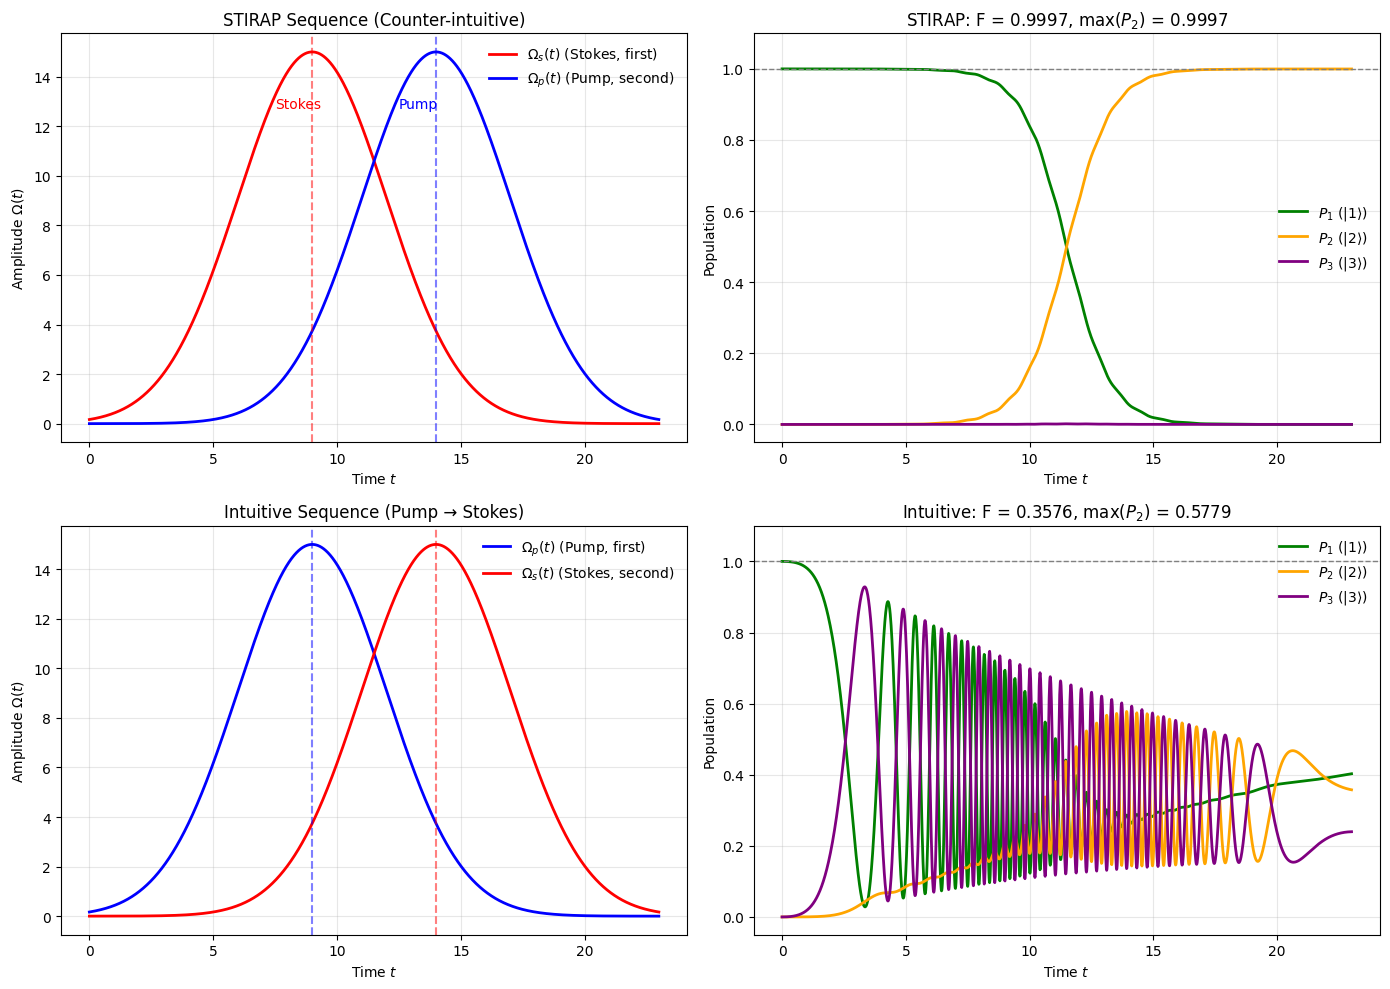


COMPARACIÓN: STIRAP vs Secuencia Intuitiva
Métrica                             STIRAP          Intuitiva      
----------------------------------------------------------------------
Fidelidad final                             0.9997         0.3576
Población máxima en |2⟩                     0.9997         0.5779


In [5]:
# ==================== VISUALIZACIÓN STIRAP (2x2) ====================

import matplotlib.pyplot as plt
import numpy as np

ops = build_ops()

# Parámetros de pulsos
Omega13, Omega23 = 15.0, 15.0
Tsep = 5.0
sigma_pulse = 3.0

# tiempo de simulación (debe cubrir todo el rango de los pulsos)
t_offset = 3 * sigma_pulse
t_total = t_offset + Tsep + 3*sigma_pulse
tlist = np.linspace(0, t_total, 2001)

# condiciones
rho0 = qt.ket2dm(ops["e1"])          # ρ(0)=|1><1|
ket_target = ops["e2"]               # objetivo: |2>
delta = 0.0
Delta2 = 0.0
# gammas = (Decaimiento 3->1, 3->2, Desfase 1, Desfase 2, Desfase 3)
Gamma_total_decay = 0.1
gammas = (Gamma_total_decay/2, Gamma_total_decay/2, 0.0, 0.0, 0.0)

# Función run_stirap (faltaba definir)
def run_stirap(order, Omega13=10.0, Omega23=10.0, Tsep=5.0, sigma=3.0):
    tp, ts = stirap_times(Tsep, order=order)
    Op, Os = gaussian_pulses(Omega13, Omega23, tp, ts, sigma)
    H, c_ops = make_H_and_cops(ops, delta, Delta2, Op, Os, gammas)
    pops, rhoT = simulate_mastereq(ops, H, c_ops, tlist, rho0)
    F = fidelity_target_pure(rhoT, ket_target)
    return Op, Os, pops, F

# Ejecutar ambas secuencias
OpC, OsC, popsC, FC = run_stirap("counter", Omega13, Omega23, Tsep, sigma_pulse)
OpI, OsI, popsI, FI = run_stirap("intuitive", Omega13, Omega23, Tsep, sigma_pulse)

# Extraer poblaciones
P1C, P2C, P3C = popsC
P1I, P2I, P3I = popsI

# Calcular máximos de P2
P2_max_counter = np.max(P2C)
P2_max_intuitive = np.max(P2I)

# Tiempos centrales de pulsos
tp_counter, ts_counter = stirap_times(Tsep, order="counter")
tp_intuitive, ts_intuitive = stirap_times(Tsep, order="intuitive")

# ==================== FIGURA 2x2 ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ========== Subplot 1: Pulsos STIRAP (Contra-intuitiva) ==========
ax1 = axes[0, 0]
Omega_s_array = np.array([OsC(t, None) for t in tlist])
Omega_p_array = np.array([OpC(t, None) for t in tlist])

ax1.plot(tlist, Omega_s_array, 'r-', linewidth=2, label=r'$\Omega_s(t)$ (Stokes, first)')
ax1.plot(tlist, Omega_p_array, 'b-', linewidth=2, label=r'$\Omega_p(t)$ (Pump, second)')
ax1.axvline(x=ts_counter, color='r', linestyle='--', alpha=0.5)
ax1.axvline(x=tp_counter, color='b', linestyle='--', alpha=0.5)
ax1.set_xlabel(r'Time $t$')
ax1.set_ylabel(r'Amplitude $\Omega(t)$')
ax1.set_title('STIRAP Sequence (Counter-intuitive)')
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.3)
ax1.text(ts_counter-1.5, Omega23*0.85, 'Stokes', fontsize=10, color='red')
ax1.text(tp_counter-1.5, Omega13*0.85, 'Pump', fontsize=10, color='blue')

# ========== Subplot 2: Poblaciones STIRAP ==========
ax2 = axes[0, 1]
ax2.plot(tlist, P1C, 'g-', linewidth=2, label=r'$P_1$ (|1⟩)')
ax2.plot(tlist, P2C, 'orange', linewidth=2, label=r'$P_2$ (|2⟩)')
ax2.plot(tlist, P3C, 'purple', linewidth=2, label=r'$P_3$ (|3⟩)')
ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel(r'Time $t$')
ax2.set_ylabel('Population')
ax2.set_title(f'STIRAP: F = {FC:.4f}, max($P_2$) = {P2_max_counter:.4f}')
ax2.legend(frameon=False)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([-0.05, 1.1])

# ========== Subplot 3: Pulsos Intuitivos ==========
ax3 = axes[1, 0]
Omega_s_int = np.array([OsI(t, None) for t in tlist])
Omega_p_int = np.array([OpI(t, None) for t in tlist])

ax3.plot(tlist, Omega_p_int, 'b-', linewidth=2, label=r'$\Omega_p(t)$ (Pump, first)')
ax3.plot(tlist, Omega_s_int, 'r-', linewidth=2, label=r'$\Omega_s(t)$ (Stokes, second)')
ax3.axvline(x=tp_intuitive, color='b', linestyle='--', alpha=0.5)
ax3.axvline(x=ts_intuitive, color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel(r'Time $t$')
ax3.set_ylabel(r'Amplitude $\Omega(t)$')
ax3.set_title('Intuitive Sequence (Pump → Stokes)')
ax3.legend(frameon=False)
ax3.grid(True, alpha=0.3)

# ========== Subplot 4: Poblaciones Intuitiva ==========
ax4 = axes[1, 1]
ax4.plot(tlist, P1I, 'g-', linewidth=2, label=r'$P_1$ (|1⟩)')
ax4.plot(tlist, P2I, 'orange', linewidth=2, label=r'$P_2$ (|2⟩)')
ax4.plot(tlist, P3I, 'purple', linewidth=2, label=r'$P_3$ (|3⟩)')
ax4.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
ax4.set_xlabel(r'Time $t$')
ax4.set_ylabel('Population')
ax4.set_title(f'Intuitive: F = {FI:.4f}, max($P_2$) = {P2_max_intuitive:.4f}')
ax4.legend(frameon=False)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([-0.05, 1.1])

plt.tight_layout()
plt.show()

# ==================== RESUMEN ====================
print("\n" + "="*70)
print("COMPARACIÓN: STIRAP vs Secuencia Intuitiva")
print("="*70)
print(f"{'Métrica':<35} {'STIRAP':<15} {'Intuitiva':<15}")
print("-"*70)
print(f"{'Fidelidad final':<35} {FC:>14.4f} {FI:>14.4f}")
print(f"{'Población máxima en |2⟩':<35} {P2_max_counter:>14.4f} {P2_max_intuitive:>14.4f}")
print("="*70)

In [12]:
# ==================== OPTIMIZACIÓN DE PARÁMETROS STIRAP ====================
# Similar a quantum_control_lecture.ipynb - Nelder-Mead optimization

from scipy.optimize import minimize
import numpy as np
import qutip as qt

ops = build_ops()

# Parámetros base
sigma_pulse = 3.0
t_offset = 3 * sigma_pulse
Tsep_base = 5.0
t_total = t_offset + Tsep_base + 3 * sigma_pulse
tlist_opt = np.linspace(0, t_total, 501)  # menos puntos para optimización rápida

# Estado inicial
psi0 = ops["e1"]
gamma = 0.1

# Operadores
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]
e_ops = [ops["s11"], ops["s22"], ops["s33"]]
c_ops = [np.sqrt(gamma) * ops["s13"]]  # decay |3⟩→|1⟩

def pump_pulse(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

def objective_stirap(params):
    """Función objetivo: minimizar -fidelidad (para maximizar fidelidad)"""
    A_pump, A_stokes, t_pump, t_stokes, sigma = params
    
    # Restricciones físicas
    if A_pump < 0.5 or A_stokes < 0.5 or sigma < 0.5:
        return 1.0  # penalizar
    if t_pump < 0 or t_stokes < 0 or t_pump > t_total or t_stokes > t_total:
        return 1.0
    
    args = {
        'A_pump': A_pump,
        'A_stokes': A_stokes,
        't_pump': t_pump,
        't_stokes': t_stokes,
        'sigma': sigma
    }
    
    H = [
        0 * ops["s22"],  # delta = 0
        [H_pump_op, pump_pulse],
        [H_stokes_op, stokes_pulse]
    ]
    
    try:
        result = qt.mesolve(H, psi0, tlist_opt, c_ops, e_ops, args=args)
        fidelity = result.expect[1][-1]  # población final en |2⟩
        return -fidelity  # negativo porque minimize() busca mínimo
    except:
        return 1.0

# Parámetros iniciales (STIRAP estándar)
tp_init, ts_init = stirap_times(Tsep_base, order="counter")
x0 = [2.0, 2.0, tp_init, ts_init, sigma_pulse]

print("="*70)
print("OPTIMIZACIÓN DE PARÁMETROS STIRAP (Nelder-Mead)")
print("="*70)
print()
print("Parámetros iniciales:")
print(f"  A_pump = {x0[0]:.2f}, A_stokes = {x0[1]:.2f}")
print(f"  t_pump = {x0[2]:.2f}, t_stokes = {x0[3]:.2f}")
print(f"  sigma = {x0[4]:.2f}")
print()
print("Iniciando optimización...")
print("(Esto puede tardar ~30 segundos)")
print()

# Optimizar
result_opt = minimize(objective_stirap, x0, method='Nelder-Mead',
                      options={'maxiter': 100, 'xatol': 0.01, 'fatol': 0.0001})

# Extraer parámetros óptimos
A_pump_opt, A_stokes_opt, t_pump_opt, t_stokes_opt, sigma_opt = result_opt.x

print("Optimización completada.")
print()
print("-"*70)
print("PARÁMETROS ÓPTIMOS")
print("-"*70)
print(f"  A_pump   = {A_pump_opt:.4f} (inicial: {x0[0]:.4f})")
print(f"  A_stokes = {A_stokes_opt:.4f} (inicial: {x0[1]:.4f})")
print(f"  t_pump   = {t_pump_opt:.4f} (inicial: {x0[2]:.4f})")
print(f"  t_stokes = {t_stokes_opt:.4f} (inicial: {x0[3]:.4f})")
print(f"  sigma    = {sigma_opt:.4f} (inicial: {x0[4]:.4f})")
print()
print(f"  Fidelidad óptima: {-result_opt.fun:.6f}")
print("-"*70)

# Guardar parámetros optimizados para usar en los mapas
args_optimized = {
    't_pump': t_pump_opt,
    't_stokes': t_stokes_opt,
    'A_pump': A_pump_opt,
    'A_stokes': A_stokes_opt,
    'sigma': sigma_opt
}

print()
print("Los parámetros optimizados se usarán para los mapas de fidelidad.")
print("="*70)

OPTIMIZACIÓN DE PARÁMETROS STIRAP (Nelder-Mead)

Parámetros iniciales:
  A_pump = 2.00, A_stokes = 2.00
  t_pump = 14.00, t_stokes = 9.00
  sigma = 3.00

Iniciando optimización...
(Esto puede tardar ~30 segundos)



d:\Files\Simposio2025\.venv\Lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Optimización completada.

----------------------------------------------------------------------
PARÁMETROS ÓPTIMOS
----------------------------------------------------------------------
  A_pump   = 3.8220 (inicial: 2.0000)
  A_stokes = 3.1425 (inicial: 2.0000)
  t_pump   = 6.3711 (inicial: 14.0000)
  t_stokes = 3.8012 (inicial: 9.0000)
  sigma    = 1.7088 (inicial: 3.0000)

  Fidelidad óptima: 0.998166
----------------------------------------------------------------------

Los parámetros optimizados se usarán para los mapas de fidelidad.


In [31]:
# ==================== MAPAS DE FIDELIDAD (IGUAL A REFERENCIA) ====================

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Funciones base
ops = build_ops()

# Parámetros de pulsos
Tsep, sigma_pulse = 5.0, 3.0

# Tiempo de simulación
t_offset = 3 * sigma_pulse
t_total = t_offset + Tsep + 3 * sigma_pulse
tlist_stirap = np.linspace(0, t_total, 2001)

# Estado inicial y objetivo
psi0_lambda = ops["e1"]  # Estado puro |1⟩
delta = 0.0
gamma = 0.1  # Valor de referencia para mapa 1

# NOTA: args_optimized viene de la celda anterior (optimización Nelder-Mead)
# Si no se ejecutó, usar valores por defecto
try:
    _ = args_optimized['A_pump']
    print(f"Usando parámetros optimizados: A_pump={args_optimized['A_pump']:.3f}, A_stokes={args_optimized['A_stokes']:.3f}")
except:
    tp_opt, ts_opt = stirap_times(Tsep, order="counter")
    args_optimized = {
        't_pump': tp_opt,
        't_stokes': ts_opt,
        'A_pump': 2.5,
        'A_stokes': 2.5,
        'sigma': sigma_pulse
    }
    print("Usando parámetros por defecto (ejecute la celda de optimización primero)")

# Operadores del Hamiltoniano (como en referencia)
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]

# Funciones de pulso (como en referencia)
def pump_pulse_stirap(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse_stirap(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

# Operadores de expectación: P1, P2, P3
e_ops_lambda = [ops["s11"], ops["s22"], ops["s33"]]

# Hamiltoniano STIRAP base (para mapa 2)
H_stirap = [
    delta * ops["s22"],
    [H_pump_op, pump_pulse_stirap],
    [H_stokes_op, stokes_pulse_stirap]
]

# ==================== MAPA 1: DETUNING VS GAMMA ====================
print("="*70)
print("MAPA DE FIDELIDAD 2D: Detuning vs Tasa de Decaimiento")
print("="*70)
print()

delta_grid = np.linspace(-1.5, 1.5, 25)
gamma_grid = np.linspace(0.0, 0.25, 25)
fidelity_map_1 = np.zeros((len(gamma_grid), len(delta_grid)))

print(f"Calculando mapa {len(gamma_grid)}×{len(delta_grid)} = {len(gamma_grid)*len(delta_grid)} puntos...")
print("(Esto puede tardar ~10-15 segundos)")
print()

for i, g in enumerate(gamma_grid):
    for j, d in enumerate(delta_grid):
        # Hamiltoniano con detuning variable
        H0_d = d * ops["s22"]  # delta * |2⟩⟨2|
        H_temp = [
            H0_d,
            [H_pump_op, pump_pulse_stirap],
            [H_stokes_op, stokes_pulse_stirap]
        ]
        
        # Operador de colapso: decay |3⟩→|1⟩
        c_ops_temp = [np.sqrt(g) * ops["s13"]] if g > 0 else []
        
        # Simular
        result = qt.mesolve(H_temp, psi0_lambda, tlist_stirap,
                            c_ops_temp, e_ops_lambda, args=args_optimized)
        
        # Fidelidad = población final en |2⟩ (objetivo del STIRAP)
        fidelity_map_1[i, j] = result.expect[1][-1]  # P2 = expect[1]

print("Cálculo completado.")
print()

# Estadísticas del mapa
print("-"*70)
print("ESTADÍSTICAS DEL MAPA 1")
print("-"*70)
print(f"Fidelidad promedio: {np.mean(fidelity_map_1):.6f}")
print(f"Desviación estándar: {np.std(fidelity_map_1):.6f}")
print(f"Fidelidad mínima:   {fidelity_map_1.min():.6f}")
print(f"Fidelidad máxima:   {fidelity_map_1.max():.6f}")
print("-"*70)

# ==================== MAPA 2: AMPLITUDES PUMP VS STOKES ====================
print("\n" + "="*70)
print("MAPA DE FIDELIDAD 2D: A_pump vs A_stokes")
print("="*70)
print()

# Rango de amplitudes (centrado alrededor del óptimo ~2.9)
A_pump_grid = np.linspace(1.5, 4.0, 25)
A_stokes_grid = np.linspace(1.5, 4.0, 25)
fidelity_map_2 = np.zeros((len(A_stokes_grid), len(A_pump_grid)))

# Usar el mismo gamma que en el mapa 1
c_ops_lambda = [np.sqrt(gamma) * ops["s13"]]  # decay |3⟩→|1⟩

print(f"Calculando mapa {len(A_stokes_grid)}×{len(A_pump_grid)} = {len(A_stokes_grid)*len(A_pump_grid)} puntos...")
print(f"(γ = {gamma} para este mapa)")
print()

for i, A_s in enumerate(A_stokes_grid):
    for j, A_p in enumerate(A_pump_grid):
        # Actualizar parámetros
        args_temp = args_optimized.copy()
        args_temp['A_pump'] = A_p
        args_temp['A_stokes'] = A_s
        
        # Simular con H_stirap
        result = qt.mesolve(H_stirap, psi0_lambda, tlist_stirap,
                            c_ops_lambda, e_ops_lambda, args=args_temp)
        
        # Fidelidad = población final en |2⟩
        fidelity_map_2[i, j] = result.expect[1][-1]  # P2 = expect[1]

print("Cálculo completado.")
print()

# Encontrar punto óptimo
opt_idx = np.unravel_index(np.argmax(fidelity_map_2), fidelity_map_2.shape)
A_stokes_optimal = A_stokes_grid[opt_idx[0]]
A_pump_optimal = A_pump_grid[opt_idx[1]]

print("-"*70)
print("ESTADÍSTICAS DEL MAPA 2")
print("-"*70)
print(f"Fidelidad promedio: {np.mean(fidelity_map_2):.6f}")
print(f"Desviación estándar: {np.std(fidelity_map_2):.6f}")
print(f"Fidelidad mínima:   {fidelity_map_2.min():.6f}")
print(f"Fidelidad máxima:   {fidelity_map_2.max():.6f}")
print()
print(f"Punto óptimo en la grilla:")
print(f"  A_pump   = {A_pump_optimal:.3f}")
print(f"  A_stokes = {A_stokes_optimal:.3f}")
print(f"  Fidelidad = {fidelity_map_2[opt_idx]:.6f}")
print("-"*70)
print("="*70)

Usando parámetros optimizados: A_pump=3.822, A_stokes=3.142
MAPA DE FIDELIDAD 2D: Detuning vs Tasa de Decaimiento

Calculando mapa 25×25 = 625 puntos...
(Esto puede tardar ~10-15 segundos)



d:\Files\Simposio2025\.venv\Lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Cálculo completado.

----------------------------------------------------------------------
ESTADÍSTICAS DEL MAPA 1
----------------------------------------------------------------------
Fidelidad promedio: 0.990413
Desviación estándar: 0.007366
Fidelidad mínima:   0.969420
Fidelidad máxima:   0.999901
----------------------------------------------------------------------

MAPA DE FIDELIDAD 2D: A_pump vs A_stokes

Calculando mapa 25×25 = 625 puntos...
(γ = 0.1 para este mapa)

Cálculo completado.

----------------------------------------------------------------------
ESTADÍSTICAS DEL MAPA 2
----------------------------------------------------------------------
Fidelidad promedio: 0.991533
Desviación estándar: 0.005894
Fidelidad mínima:   0.961239
Fidelidad máxima:   0.998179

Punto óptimo en la grilla:
  A_pump   = 3.792
  A_stokes = 3.167
  Fidelidad = 0.998179
----------------------------------------------------------------------


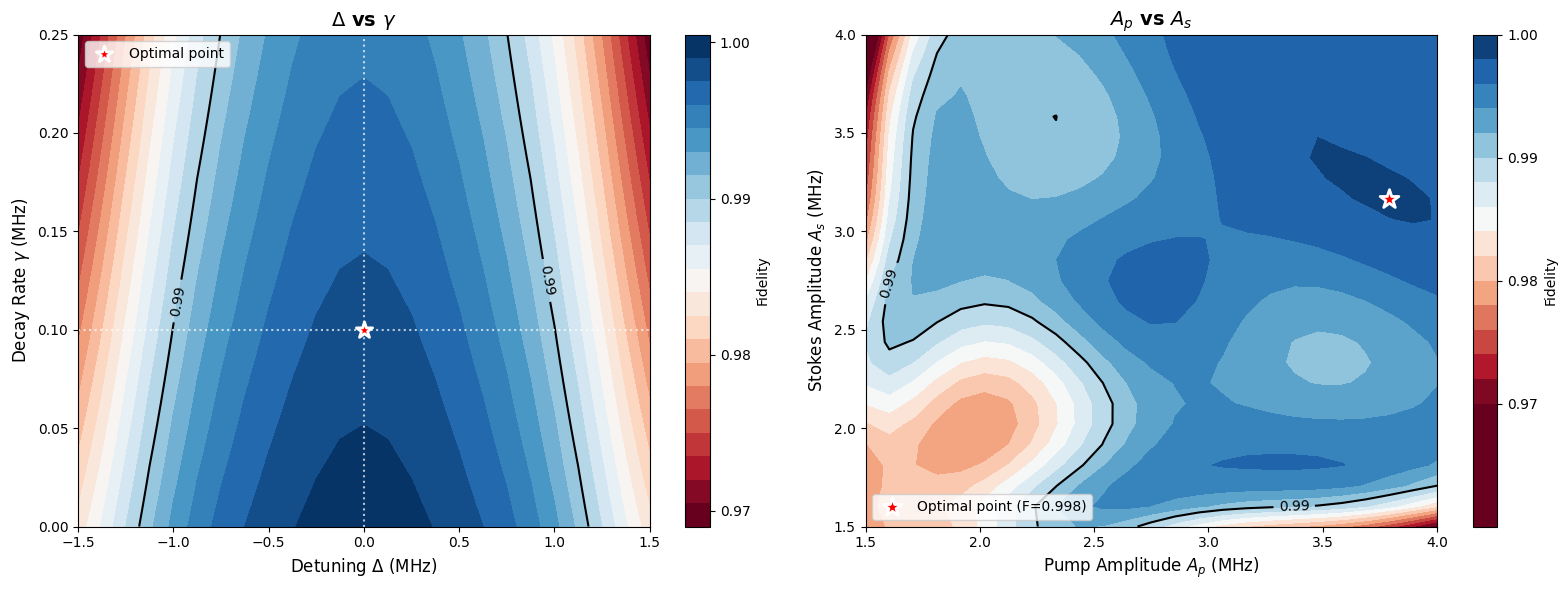


=== Estadísticas Mapa 1 (Δ vs γ) ===
Fidelidad mín: 0.9694, máx: 0.9999

=== Estadísticas Mapa 2 (Ap vs As) ===
Fidelidad mín: 0.9612, máx: 0.9982
Óptimo global: Ap=3.79, As=3.17, F=0.9982


In [32]:
# ==================== VISUALIZACIÓN DE MAPAS 2D ====================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Parámetros para forzar el zoom en la escala de color
VMIN_ZOOM = 0.97
VMAX_ZOOM = 1.0

# ========== Subplot 1: Mapa (Δ, γ) ==========
ax1 = axes[0]
im1 = ax1.contourf(delta_grid, gamma_grid, fidelity_map_1,
                    levels=20, cmap='RdBu', vmin=VMIN_ZOOM, vmax=VMAX_ZOOM)
contours1 = ax1.contour(delta_grid, gamma_grid, fidelity_map_1,
                        levels=[0.90, 0.95, 0.99], colors='black',
                        linewidths=1.5, linestyles=[':', '--', '-'])
ax1.clabel(contours1, inline=True, fontsize=10, fmt='%.2f')

# Marcar punto óptimo (delta=0, gamma de referencia)
ax1.axvline(x=0, color='white', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axhline(y=gamma, color='white', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.scatter([0], [gamma], c='red', s=150, marker='*',
            edgecolors='white', linewidths=2, zorder=10, label='Optimal point')

ax1.set_xlabel(r'Detuning $\Delta$ (MHz)', fontsize=12)
ax1.set_ylabel(r'Decay Rate $\gamma$ (MHz)', fontsize=12)
ax1.set_title(r'$\Delta$ vs $\gamma$', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
cbar1 = plt.colorbar(im1, ax=ax1, label='Fidelity')
cbar1.set_ticks([0.97, 0.98, 0.99, 1.00])
cbar1.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# ========== Subplot 2: Mapa (A_pump, A_stokes) ==========
ax2 = axes[1]
im2 = ax2.contourf(A_pump_grid, A_stokes_grid, fidelity_map_2,
                    levels=20, cmap='RdBu', vmin=VMIN_ZOOM, vmax=VMAX_ZOOM)
contours2 = ax2.contour(A_pump_grid, A_stokes_grid, fidelity_map_2,
                        levels=[0.90, 0.95, 0.99], colors='black',
                        linewidths=1.5, linestyles=[':', '--', '-'])
ax2.clabel(contours2, inline=True, fontsize=10, fmt='%.2f')

# Encontrar punto óptimo global (máxima fidelidad)
opt_idx = np.unravel_index(np.argmax(fidelity_map_2), fidelity_map_2.shape)
A_pump_opt = A_pump_grid[opt_idx[1]]
A_stokes_opt = A_stokes_grid[opt_idx[0]]
F_opt = fidelity_map_2[opt_idx]

# Marcar óptimo global (máxima fidelidad en la grilla)
ax2.scatter([A_pump_opt], [A_stokes_opt], c='red', s=200, marker='*',
            edgecolors='white', linewidths=2, zorder=10, 
            label=f'Optimal point (F={F_opt:.3f})')

ax2.set_xlabel(r'Pump Amplitude $A_p$ (MHz)', fontsize=12)
ax2.set_ylabel(r'Stokes Amplitude $A_s$ (MHz)', fontsize=12)
ax2.set_title(r'$A_p$ vs $A_s$', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')

cbar2 = plt.colorbar(im2, ax=ax2, label='Fidelity')
cbar2.set_ticks([0.97, 0.98, 0.99, 1.00])
cbar2.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
plt.savefig('mapa_fidelidad.pdf', format='pdf')
plt.show()

# ==================== ESTADÍSTICAS ====================
print(f"\n=== Estadísticas Mapa 1 (Δ vs γ) ===")
print(f"Fidelidad mín: {fidelity_map_1.min():.4f}, máx: {fidelity_map_1.max():.4f}")

print(f"\n=== Estadísticas Mapa 2 (Ap vs As) ===")
print(f"Fidelidad mín: {fidelity_map_2.min():.4f}, máx: {fidelity_map_2.max():.4f}")
print(f"Óptimo global: Ap={A_pump_opt:.2f}, As={A_stokes_opt:.2f}, F={F_opt:.4f}")

In [8]:
# ==================== OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION ====================

from scipy.optimize import differential_evolution
import numpy as np
import qutip as qt

print("="*70)
print("OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION")
print("="*70)
print()

# Usar operadores ya definidos
ops = build_ops()

# Parámetros base
t_total = 23.0
tlist_robust = np.linspace(0, t_total, 501)
psi0 = ops["e1"]
gamma_nominal = 0.1

# Operadores del Hamiltoniano
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]
e_ops = [ops["s11"], ops["s22"], ops["s33"]]

def pump_pulse_robust(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse_robust(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

# Ensemble de detunings (distribución para robustez)
n_samples_ensemble = 10  # Número de muestras del ensemble
detuning_std = 0.5  # Desviación estándar del detuning (MHz)
np.random.seed(42)
detuning_samples = np.random.normal(0, detuning_std, n_samples_ensemble)

def objective_robust(params):
    """
    Función objetivo para optimización robusta.
    Minimiza 1 - <F> donde <F> es fidelidad promedio sobre ensemble de detunings.
    """
    A_pump, A_stokes, sigma = params
    
    # Restricciones
    if A_pump < 0.5 or A_stokes < 0.5 or sigma < 0.5:
        return 1.0
    
    # Tiempos fijos (STIRAP estándar)
    t_pump = 14.0
    t_stokes = 9.0
    
    args = {
        'A_pump': A_pump,
        'A_stokes': A_stokes,
        't_pump': t_pump,
        't_stokes': t_stokes,
        'sigma': sigma
    }
    
    fidelities = []
    c_ops = [np.sqrt(gamma_nominal) * ops["s13"]]
    
    for delta in detuning_samples:
        H = [
            delta * ops["s22"],
            [H_pump_op, pump_pulse_robust],
            [H_stokes_op, stokes_pulse_robust]
        ]
        
        try:
            result = qt.mesolve(H, psi0, tlist_robust, c_ops, e_ops, args=args)
            fidelities.append(result.expect[1][-1])  # P2 final
        except:
            fidelities.append(0.0)
    
    # Minimizar 1 - fidelidad promedio
    return 1.0 - np.mean(fidelities)

# Límites para los parámetros [A_pump, A_stokes, sigma]
bounds = [(1.0, 5.0), (1.0, 5.0), (1.0, 4.0)]

print("Configuración:")
print(f"  Muestras del ensemble: {n_samples_ensemble}")
print(f"  Desviación de detuning: ±{detuning_std:.2f} MHz")
print(f"  γ nominal: {gamma_nominal}")
print()
print("Límites de búsqueda:")
print(f"  A_pump  ∈ [{bounds[0][0]:.1f}, {bounds[0][1]:.1f}] MHz")
print(f"  A_stokes ∈ [{bounds[1][0]:.1f}, {bounds[1][1]:.1f}] MHz")
print(f"  sigma   ∈ [{bounds[2][0]:.1f}, {bounds[2][1]:.1f}]")
print()
print("Iniciando optimización...")
print("(Esto puede tardar ~60-120 segundos)")
print()

# Optimizar con Differential Evolution
result_robust = differential_evolution(
    objective_robust,
    bounds,
    seed=42,
    maxiter=50,    # Reducido para demo (usar 200+ en producción)
    popsize=10,    # Tamaño de población
    tol=0.01,
    atol=0.001,
    disp=True      # Mostrar progreso
)

A_pump_robust, A_stokes_robust, sigma_robust = result_robust.x

print()
print("Optimización completada.")
print()
print("-"*70)
print("PARÁMETROS ROBUSTOS OPTIMIZADOS")
print("-"*70)
print(f"  A_pump   = {A_pump_robust:.4f} MHz")
print(f"  A_stokes = {A_stokes_robust:.4f} MHz")
print(f"  sigma    = {sigma_robust:.4f}")
print()
print(f"  Fidelidad promedio: {1.0 - result_robust.fun:.6f}")
print("-"*70)

# Guardar parámetros robustos
args_robust = {
    't_pump': 14.0,
    't_stokes': 9.0,
    'A_pump': A_pump_robust,
    'A_stokes': A_stokes_robust,
    'sigma': sigma_robust
}

print()
print("="*70)

OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION

Configuración:
  Muestras del ensemble: 10
  Desviación de detuning: ±0.50 MHz
  γ nominal: 0.1

Límites de búsqueda:
  A_pump  ∈ [1.0, 5.0] MHz
  A_stokes ∈ [1.0, 5.0] MHz
  sigma   ∈ [1.0, 4.0]

Iniciando optimización...
(Esto puede tardar ~60-120 segundos)



d:\Files\Simposio2025\.venv\Lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


differential_evolution step 1: f(x)= 0.001429634106646538
differential_evolution step 2: f(x)= 0.001429634106646538
differential_evolution step 3: f(x)= 0.001234243170197602
differential_evolution step 4: f(x)= 0.001234243170197602
differential_evolution step 5: f(x)= 0.001234243170197602
Polishing solution with 'L-BFGS-B'

Optimización completada.

----------------------------------------------------------------------
PARÁMETROS ROBUSTOS OPTIMIZADOS
----------------------------------------------------------------------
  A_pump   = 5.0000 MHz
  A_stokes = 5.0000 MHz
  sigma    = 2.9229

  Fidelidad promedio: 0.998938
----------------------------------------------------------------------



COMPARACIÓN: PARÁMETROS ESTÁNDAR VS ROBUSTOS

Evaluando parámetros estándar vs robustos...
Evaluación completada.

----------------------------------------------------------------------
ESTADÍSTICAS DE COMPARACIÓN
----------------------------------------------------------------------
Métrica                        Estándar        Robusto        
----------------------------------------------------------------------
Fidelidad promedio             0.985237       0.997142
Fidelidad mínima               0.960593       0.992591
Fidelidad máxima               0.997647       0.999383
Desviación estándar            0.011911       0.002098
----------------------------------------------------------------------

✓ Mejora en fidelidad promedio: +0.011904
✓ Mejora en fidelidad mínima: +0.031999

Evaluando ensemble de detunings para distribución...
Evaluación completada.


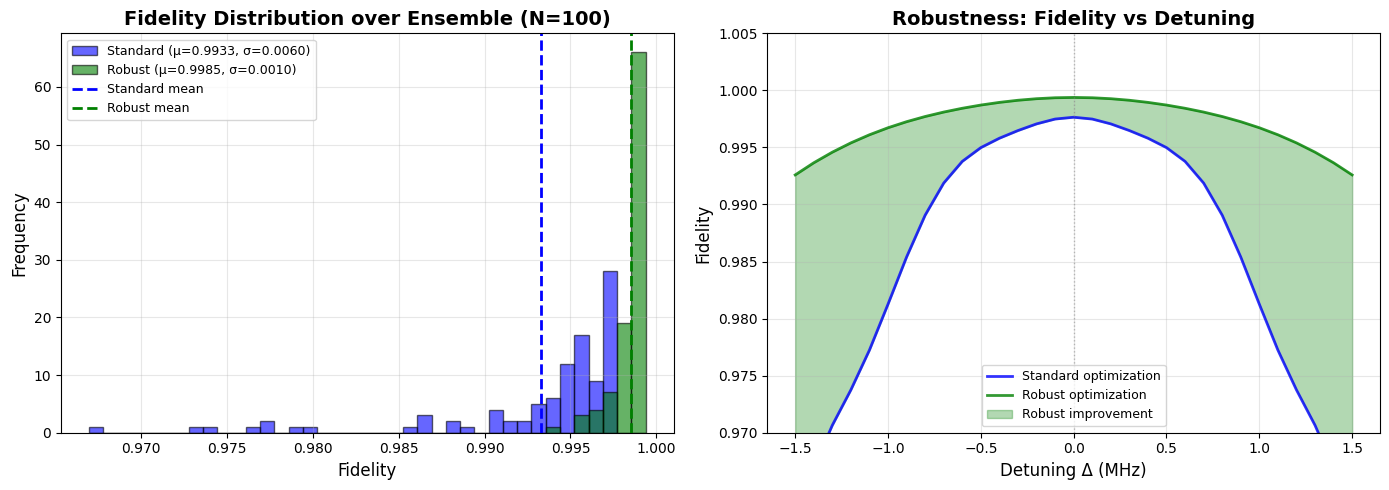


Conclusión:
  La optimización robusta (Differential Evolution) busca maximizar
  la fidelidad PROMEDIO sobre un ensemble de detunings, lo que
  produce parámetros más tolerantes a variaciones experimentales.


In [9]:
# ==================== COMPARACIÓN: PARÁMETROS ESTÁNDAR VS ROBUSTOS ====================

import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("COMPARACIÓN: PARÁMETROS ESTÁNDAR VS ROBUSTOS")
print("="*70)
print()

# Rango de detunings para evaluar
delta_test_range = np.linspace(-1.5, 1.5, 31)

# Evaluar ambos conjuntos de parámetros
fidelities_standard = []
fidelities_robust_eval = []

c_ops_test = [np.sqrt(gamma_nominal) * ops["s13"]]

print("Evaluando parámetros estándar vs robustos...")

for delta in delta_test_range:
    H_temp = [
        delta * ops["s22"],
        [H_pump_op, pump_pulse_robust],
        [H_stokes_op, stokes_pulse_robust]
    ]
    
    # Evaluar con parámetros estándar (de la optimización local)
    result_std = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_optimized)
    fidelities_standard.append(result_std.expect[1][-1])
    
    # Evaluar con parámetros robustos
    result_rob = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_robust)
    fidelities_robust_eval.append(result_rob.expect[1][-1])

fidelities_standard = np.array(fidelities_standard)
fidelities_robust_eval = np.array(fidelities_robust_eval)

print("Evaluación completada.")
print()

# Estadísticas
print("-"*70)
print("ESTADÍSTICAS DE COMPARACIÓN")
print("-"*70)
print(f"{'Métrica':<30} {'Estándar':<15} {'Robusto':<15}")
print("-"*70)
print(f"{'Fidelidad promedio':<30} {np.mean(fidelities_standard):.6f}       {np.mean(fidelities_robust_eval):.6f}")
print(f"{'Fidelidad mínima':<30} {np.min(fidelities_standard):.6f}       {np.min(fidelities_robust_eval):.6f}")
print(f"{'Fidelidad máxima':<30} {np.max(fidelities_standard):.6f}       {np.max(fidelities_robust_eval):.6f}")
print(f"{'Desviación estándar':<30} {np.std(fidelities_standard):.6f}       {np.std(fidelities_robust_eval):.6f}")
print("-"*70)

# Mejora
mejora_promedio = np.mean(fidelities_robust_eval) - np.mean(fidelities_standard)
mejora_minima = np.min(fidelities_robust_eval) - np.min(fidelities_standard)

print()
if mejora_promedio > 0:
    print(f"✓ Mejora en fidelidad promedio: +{mejora_promedio:.6f}")
else:
    print(f"  Sin mejora significativa en promedio: {mejora_promedio:.6f}")

if mejora_minima > 0:
    print(f"✓ Mejora en fidelidad mínima: +{mejora_minima:.6f}")
else:
    print(f"  Sin mejora significativa en mínimo: {mejora_minima:.6f}")
    
print()
print("="*70)

# ==================== VISUALIZACIÓN ====================

# Generar ensemble aleatorio para distribución de fidelidades
n_ensemble = 100
np.random.seed(123)
detunings_ensemble = np.random.normal(0, 0.5, n_ensemble)  # σ = 0.5 MHz

fidelities_std_ensemble = []
fidelities_rob_ensemble = []

print("Evaluando ensemble de detunings para distribución...")

for delta in detunings_ensemble:
    H_temp = [
        delta * ops["s22"],
        [H_pump_op, pump_pulse_robust],
        [H_stokes_op, stokes_pulse_robust]
    ]
    
    result_std = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_optimized)
    fidelities_std_ensemble.append(result_std.expect[1][-1])
    
    result_rob = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_robust)
    fidelities_rob_ensemble.append(result_rob.expect[1][-1])

fidelities_std_ensemble = np.array(fidelities_std_ensemble)
fidelities_rob_ensemble = np.array(fidelities_rob_ensemble)

# Estadísticas del ensemble
std_mean = np.mean(fidelities_std_ensemble)
std_std = np.std(fidelities_std_ensemble)
rob_mean = np.mean(fidelities_rob_ensemble)
rob_std = np.std(fidelities_rob_ensemble)

print("Evaluación completada.")

# ==================== FIGURA CON DOS SUBPLOTS ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ========== Subplot 1: Histogramas de Fidelidad ==========
ax1 = axes[0]
# Usar los mismos bins para ambos histogramas
all_fidelities = np.concatenate([fidelities_std_ensemble, fidelities_rob_ensemble])
bins_shared = np.linspace(all_fidelities.min(), all_fidelities.max(), 40)

ax1.hist(fidelities_std_ensemble, bins=bins_shared, alpha=0.6, color='blue',
         label=f'Standard (μ={std_mean:.4f}, σ={std_std:.4f})', edgecolor='black')
ax1.hist(fidelities_rob_ensemble, bins=bins_shared, alpha=0.6, color='green',
         label=f'Robust (μ={rob_mean:.4f}, σ={rob_std:.4f})', edgecolor='black')
ax1.axvline(x=std_mean, color='blue', linestyle='--', linewidth=2, label='Standard mean')
ax1.axvline(x=rob_mean, color='green', linestyle='--', linewidth=2, label='Robust mean')
ax1.set_xlabel('Fidelity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'Fidelity Distribution over Ensemble (N={n_ensemble})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# ========== Subplot 2: Fidelidad vs Detuning ==========
ax2 = axes[1]

ax2.plot(delta_test_range, fidelities_standard, 'b-', linewidth=2, 
         label='Standard optimization', alpha=0.8)
ax2.plot(delta_test_range, fidelities_robust_eval, 'g-', linewidth=2, 
         label='Robust optimization', alpha=0.8)

ax2.fill_between(delta_test_range, fidelities_standard, fidelities_robust_eval,
                 where=(fidelities_robust_eval >= fidelities_standard),
                 alpha=0.3, color='green', label='Robust improvement')
ax2.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax2.set_xlabel('Detuning Δ (MHz)', fontsize=12)
ax2.set_ylabel('Fidelity', fontsize=12)
ax2.set_title('Robustness: Fidelity vs Detuning', fontsize=14, fontweight='bold')
ax2.legend(loc='lower center', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.97, 1.00])

plt.tight_layout()
plt.savefig('comparacion_robustez.pdf', format='pdf')
plt.show()

print()
print("Conclusión:")
print("  La optimización robusta (Differential Evolution) busca maximizar")
print("  la fidelidad PROMEDIO sobre un ensemble de detunings, lo que")
print("  produce parámetros más tolerantes a variaciones experimentales.")